In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#export
from nb_003b import *
from torch import Tensor

Floats = Union[float, Collection[float]]
Rank0Tensor = typing.NewType('Rank0Tensor', Tensor)

# Hyperparameters and callbacks

## Setup

In [3]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10'

data_mean,data_std = map(tensor, ([0.491, 0.482, 0.447], [0.247, 0.243, 0.261]))
cifar_norm,cifar_denorm = normalize_funcs(data_mean,data_std)

tfms = [flip_lr_tfm(p=0.5),
        pad_tfm(padding=4),
        crop_tfm(size=32, row_pct=(0,1.), col_pct=(0,1.))]

bs = 64

In [4]:
train_ds = FilesDataset.from_folder(PATH/'train', classes=['airplane','dog'])
valid_ds = FilesDataset.from_folder(PATH/'test', classes=['airplane','dog'])
data = DataBunch.create(train_ds, valid_ds, bs=bs, train_tfm=tfms, num_workers=4, dl_tfms=cifar_norm)
len(data.train_dl), len(data.valid_dl)

(157, 16)

In [5]:
model = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=16)

## Setting hyperparameters easily

We want an optimizer with an easy way to set hyperparameters: they're all properties and we define custom setters to handle the different names in pytorch optimizers.

In [6]:
#export
class OptimWrapper():
    def __init__(self, opt, wd=0., true_wd=False):
        self.opt,self.true_wd = opt,true_wd
        self.opt_keys = list(self.opt.param_groups[0].keys())
        self.opt_keys.remove('params')
        self.read_defaults()
        self._wd = wd
    
    #Pytorch optimizer methods
    def step(self):
        # weight decay outside of optimizer step (AdamW)
        if self.true_wd:
            for pg in self.opt.param_groups:
                for p in pg['params']: p.data.mul_(1 - self._wd*pg['lr'])
            self.set_val('weight_decay', 0)
        self.opt.step()
    
    def zero_grad(self): self.opt.zero_grad()
    
    #Hyperparameters as properties
    @property
    def lr(self): return self._lr

    @lr.setter
    def lr(self, val): self._lr = self.set_val('lr', val)
    
    @property
    def mom(self): return self._mom

    @mom.setter
    def mom(self, val):
        if 'momentum' in self.opt_keys: self.set_val('momentum', val)
        elif 'betas' in self.opt_keys:  self.set_val('betas', (val, self._beta))
        self._mom = val
    
    @property
    def beta(self): return self._beta

    @beta.setter
    def beta(self, val):
        if 'betas' in self.opt_keys:    self.set_val('betas', (self._mom,val))
        elif 'alpha' in self.opt_keys:  self.set_val('alpha', val)
        self._beta = val
    
    @property
    def wd(self): return self._wd

    @wd.setter
    def wd(self, val):
        if not self.true_wd: self.set_val('weight_decay', val)
        self._wd = val
    
    #Helper functions
    def read_defaults(self):
        self._beta = None
        if 'lr' in self.opt_keys: self._lr = self.opt.param_groups[0]['lr']
        if 'momentum' in self.opt_keys: self._mom = self.opt.param_groups[0]['momentum']
        if 'alpha' in self.opt_keys: self._beta = self.opt.param_groups[0]['alpha']
        if 'betas' in self.opt_keys: self._mom,self._beta = self.opt.param_groups[0]['betas']
        if 'weight_decay' in self.opt_keys: self._wd = self.opt.param_groups[0]['weight_decay']
    
    def set_val(self, key, val):
        for pg in self.opt.param_groups: pg[key] = val
        return val

In [7]:
opt_fn = partial(optim.Adam, betas=(0.95,0.99))
opt = OptimWrapper(opt_fn(model.parameters(), 1e-2))
opt.lr, opt.mom, opt.wd, opt.beta

(0.01, 0.95, 0.0, 0.99)

In [8]:
opt.lr=0.2
opt.lr, opt.mom, opt.wd, opt.beta

(0.2, 0.95, 0.0, 0.99)

## Callbacks

Now that it's easy to set and change the HP in the optimizer, we need a scheduler to change it. To keep the training loop as readable as possible we don't want to handle all of this stuff inside it so we'll use callbacks. 

In [9]:
#export
class Callback():
    def on_train_begin(self, **kwargs): pass         
        #To initiliaze constants in the callback.
    def on_epoch_begin(self, **kwargs): pass
        #At the beginning of each epoch
    def on_batch_begin(self, **kwargs): pass 
        #To set HP before the step is done. 
        #Returns xb, yb (which can allow us to modify the input at that step if needed)
    def on_loss_begin(self, **kwargs): pass
        #Called after the forward pass but before the loss has been computed.
        #Returns the output (which can allow us to modify it)
    def on_backward_begin(self, **kwargs): pass
        #Called after the forward pass and the loss has been computed, but before the back propagation.
        #Returns the loss (which can allow us to modify it, for instance for reg functions)
    def on_backward_end(self, **kwargs): pass
        #Called after the back propagation had been done (and the gradients computed) but before the step of the optimizer.
        #Useful for true weight decay in AdamW
    def on_step_end(self, **kwargs): pass
        #Called after the step of the optimizer but before the gradients are zeroed (not sure this one is useful)
    def on_batch_end(self, **kwargs): pass
        #Called at the end of the batch
    def on_epoch_end(self, **kwargs): pass
        #Called at the end of an epoch
    def on_train_end(self, **kwargs): pass
        #Useful for cleaning up things and saving files/models

To be more convenient and make the code of the training loop cleaner, we'll create a class to handle the callbacks. It will keep track of everything the training loop sends it, then pack it in the kwargs of each callback. This way, all the callbacks can access things like the epoch number, the last loss etc...

Helper class that computes a moving average of the values sent to it. Will be useful for the smooth_loss but can smoothen anything.

In [10]:
#export
class SmoothenValue():
    def __init__(self, beta):
        self.beta,self.n,self.mov_avg = beta,0,0
    
    def add_value(self, val):
        self.n += 1
        self.mov_avg = self.beta * self.mov_avg + (1 - self.beta) * val
        self.smooth = self.mov_avg / (1 - self.beta ** self.n)

In [11]:
#export
def _get_init_state(): return {'epoch':0, 'iteration':0, 'num_batch':0}

@dataclass
class CallbackHandler():
    callbacks:Collection[Callable]
    beta:float=0.98
        
    def __post_init__(self):
        self.smoothener = SmoothenValue(self.beta)
        self.state_dict:Dict[str,Union[int,float,Tensor]]=_get_init_state()
    
    def __call__(self, cb_name):
        return [getattr(cb, f'on_{cb_name}')(**self.state_dict) for cb in self.callbacks]
    
    def on_train_begin(self): 
        self.state_dict = _get_init_state()
        self('train_begin')
        
    def on_epoch_begin(self): 
        self.state_dict['num_batch'] = 0
        self('epoch_begin')
        
    def on_batch_begin(self, xb, yb):
        self.state_dict['last_input'], self.state_dict['last_target'] = xb, yb
        for cb in self.callbacks:
            a = cb.on_batch_begin(**self.state_dict)
            if a is not None: self.state_dict['last_input'], self.state_dict['last_target'] = a
        return self.state_dict['last_input'], self.state_dict['last_target']
    
    def on_loss_begin(self, out):
        self.state_dict['last_output'] = out
        for cb in self.callbacks:
            a = cb.on_loss_begin(**self.state_dict)
            if a is not None: self.state_dict['last_output'] = a
        return self.state_dict['last_output']
    
    def on_backward_begin(self, loss):
        self.smoothener.add_value(loss.item())
        self.state_dict['last_loss'], self.state_dict['smooth_loss'] = loss, self.smoothener.smooth
        for cb in self.callbacks:
            a = cb.on_backward_begin(**self.state_dict)
            if a is not None: self.state_dict['last_loss'] = a
        return self.state_dict['last_loss']
    
    def on_backward_end(self):        self('backward_end')
    def on_step_end(self):            self('step_end')
        
    def on_batch_end(self, loss):     
        self.state_dict['last_loss'] = loss
        stop = np.any(self('batch_end'))
        self.state_dict['iteration'] += 1
        self.state_dict['num_batch'] += 1
        return stop
    
    def on_epoch_end(self, val_metrics):
        self.state_dict['last_metrics'] = val_metrics
        stop = np.any(self('epoch_end'))
        self.state_dict['epoch'] += 1
        return stop
    
    def on_train_end(self): self('train_end')

The idea is to have a callback between every line of the training loop, that way everything we need to add will be treated there and not inside. We also add metrics.

In [12]:
#export
def loss_batch(model, xb, yb, loss_fn, opt=None, cb_handler=None, metrics=None):
    if cb_handler is None: cb_handler = CallbackHandler([])
    out = model(xb)
    out = cb_handler.on_loss_begin(out)
    loss = loss_fn(out, yb)
    mets = [f(out,yb).item() for f in metrics] if metrics is not None else []
    
    if opt is not None:
        loss = cb_handler.on_backward_begin(loss)
        loss.backward()
        cb_handler.on_backward_end()
        opt.step()
        cb_handler.on_step_end()
        opt.zero_grad()
        
    return (loss.item(),) + tuple(mets) + (len(xb),)

In [13]:
#export
def fit(epochs, model, loss_fn, opt, data, callbacks=None, metrics=None):
    cb_handler = CallbackHandler(callbacks)
    cb_handler.on_train_begin()
    
    for epoch in tnrange(epochs):
        model.train()
        cb_handler.on_epoch_begin()
        
        for xb,yb in data.train_dl:
            xb, yb = cb_handler.on_batch_begin(xb, yb)
            loss,_ = loss_batch(model, xb, yb, loss_fn, opt, cb_handler)
            if cb_handler.on_batch_end(loss): break
        
        if hasattr(data,'valid_dl') and data.valid_dl is not None:
            model.eval()
            with torch.no_grad():
                *val_metrics,nums = zip(*[loss_batch(model, xb, yb, loss_fn, cb_handler=cb_handler, metrics=metrics)
                                for xb,yb in data.valid_dl])
            val_metrics = [np.sum(np.multiply(val,nums)) / np.sum(nums) for val in val_metrics]
            
        else: val_metrics=None
        if cb_handler.on_epoch_end(val_metrics): break
        
    cb_handler.on_train_end()

First callback: updating the progress bar can be done and printing the validation loss in one. We'll also keep track of the losses and hyper-parameters during training for future plots (lr_finder, plot of the LR/mom schedule).

In [14]:
@dataclass
class Recorder(Callback):
    opt: torch.optim
    train_dl: DeviceDataLoader = None
    
    def on_train_begin(self, **kwargs):
        self.losses,self.val_losses,self.metrics,self.lrs,self.moms = [],[],[],[],[]
    
    def on_batch_begin(self, **kwargs):
        self.lrs.append(self.opt.lr)
        self.moms.append(self.opt.mom)
    
    def on_batch_end(self, last_loss, **kwargs):
        self.losses.append(last_loss)
        if self.train_dl is not None and self.train_dl.progress_func is not None: 
            self.train_dl.gen.set_postfix_str(last_loss)
    
    def on_epoch_end(self, epoch, last_loss, last_metrics, **kwargs):
        if last_metrics is not None:
            self.val_losses.append(last_metrics[0])
            if len(last_metrics) > 1: self.metrics.append(last_metrics[1:])
            print(epoch, last_loss, *last_metrics)
        else:  print(epoch, last_loss)

In [15]:
#export
def accuracy(out, yb):
    preds = torch.max(out, dim=1)[1]
    return (preds==yb).float().mean()

In [16]:
class Learner():
    def __init__(self, data, model):
        self.data,self.model = data,model.to(data.device)
        self.loss_fn, self.opt_fn, self.metrics = F.cross_entropy, optim.SGD, [accuracy]
        
    @property
    def train_dl(self): return self.data.train_dl
    @property
    def valid_dl(self): return self.data.train_dl if hasattr(self.data, 'valid_dl') else None

    def fit(self, epochs, lr, callbacks=None):
        if callbacks is None: callbacks=[]
        self.opt = OptimWrapper(self.opt_fn(self.model.parameters(),lr))
        self.recorder = Recorder(self.opt, self.train_dl)
        callbacks = [self.recorder] + callbacks
        fit(epochs, self.model, self.loss_fn, self.opt, self.data, callbacks=callbacks, metrics=self.metrics)

In [17]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model)

In [18]:
learn.fit(2,0.01)

0 0.2686610221862793 0.6916530467271805 0.7559999995231629


1 0.07620438933372498 0.1623351254463196 0.9355



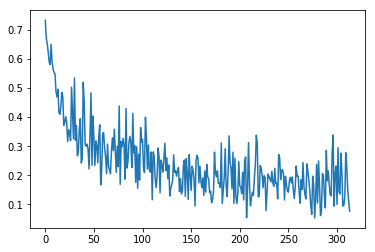

In [19]:
plt.plot(learn.recorder.losses);

## 1cycle

Now we can do a 1cycle scheduler pretty easily.

In [20]:
#export
def annealing_no(start, end, pct): return start
def annealing_linear(start, end, pct): return start + pct * (end-start)
def annealing_exp(start, end, pct): return start * (end/start) ** pct
def annealing_cos(start, end, pct):
    cos_out = np.cos(np.pi * pct) + 1
    return end + (start-end)/2 * cos_out
    
def do_annealing_poly(start, end, pct, degree): return end + (start-end) * (1-pct)**degree
def annealing_poly(degree): return functools.partial(do_annealing_poly, degree=degree)

In [21]:
import functools

In [22]:
annealings = "NO LINEAR COS EXP POLY".split()

In [23]:
a = np.arange(0, 100)
p = np.linspace(0.01,1,100)

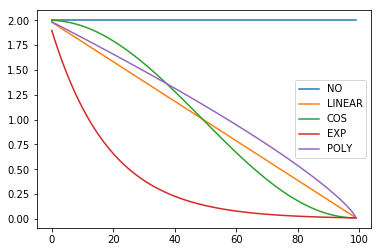

In [24]:
fns = [annealing_no, annealing_linear, annealing_cos, annealing_exp, annealing_poly(0.8)]
for fn, t in zip(fns, annealings):
    plt.plot(a, [fn(2, 1e-2, o) for o in p], label=t)
plt.legend();

In [25]:
#export
def is_tuple(x): return isinstance(x, tuple)

class Stepper():
    def __init__(self, vals, num_it, ft=None):
        self.start,self.end = (vals[0],vals[1]) if is_tuple(vals) else (vals,0)
        self.num_it = num_it
        if ft is None: self.ft = annealing_linear if is_tuple(vals) else annealing_no
        else:          self.ft = ft
        self.n = 0
    
    def step(self):
        self.n += 1
        return self.ft(self.start, self.end, self.n/self.num_it)
    
    @property
    def is_done(self):  return self.n >= self.num_it

In [26]:
#export
class OneCycleScheduler(Callback):
    def __init__(self, learn, lr_max, epochs, moms=(0.95,0.85), div_factor=10, pct_end=0.1):
        self.learn = learn
        a = int(len(learn.data.train_dl) * epochs * (1 - pct_end) / 2)
        b = len(learn.data.train_dl) * epochs - 2*a
        self.lr_scheds = [Stepper((lr_max/div_factor, lr_max), a),
                          Stepper((lr_max, lr_max/div_factor), a),
                          Stepper((lr_max/div_factor, lr_max/(div_factor*100)), b)]
        self.mom_scheds = [Stepper(moms, a), Stepper((moms[1], moms[0]), a), Stepper(moms[0], b)]
    
    def on_train_begin(self, **kwargs):
        self.opt = self.learn.opt
        self.opt.lr, self.opt.mom = self.lr_scheds[0].start, self.mom_scheds[0].start
        self.idx_s = 0
    
    def on_batch_end(self, **kwargs):
        if self.idx_s >= len(self.lr_scheds): return True
        self.opt.lr = self.lr_scheds[self.idx_s].step()
        self.opt.mom = self.mom_scheds[self.idx_s].step()
        if self.lr_scheds[self.idx_s].is_done:
            self.idx_s += 1

In [27]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model)
sched = OneCycleScheduler(learn, 0.1, 5)

In [ ]:
learn.fit(3,0.1,callbacks=[sched])

In [ ]:
iterations = list(range(len(learn.recorder.lrs)))
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(iterations, learn.recorder.lrs)
axs[1].plot(iterations, learn.recorder.moms)

## LR Finder

In [28]:
#export
@dataclass
class Learner():
    data: DataBunch
    model: nn.Module
    opt_fn: Callable = optim.SGD
#     loss_fn: LossType = F.cross_entropy
    loss_fn: Callable = F.cross_entropy
    metrics: Collection[Callable] = None
    true_wd: bool = False
    def __post_init__(self): self.model = self.model.to(self.data.device)

    def fit(self, epochs, lr, wd=0., callbacks=None):
        if not hasattr(self, 'opt'): self.create_opt(lr, wd)
        self.recorder = Recorder(self.opt, self.data.train_dl)
        if callbacks is None: callbacks = []
        callbacks = [self.recorder]+callbacks
        fit(epochs, self.model, self.loss_fn, self.opt, self.data, callbacks=callbacks, metrics=self.metrics)
    
    def create_opt(self, lr, wd=0.):
        self.opt = OptimWrapper(self.opt_fn(self.model.parameters(), lr), wd=wd, true_wd=self.true_wd)

In [29]:
#export
class LRFinder(Callback):
    def __init__(self, opt, data, start_lr=1e-5, end_lr=10, num_it=200):
        self.opt,self.data = opt,data
        self.sched = Stepper((start_lr, end_lr), num_it, annealing_exp)
        #To avoid validating if the train_dl has less than num_it batches, we put aside the valid_dl and remove it
        #during the call to fit.
        self.valid_dl = data.valid_dl
        self.data.valid_dl = None
    
    def on_train_begin(self, **kwargs):
        self.opt.lr = self.sched.start
        self.stop,self.best_loss = False,0.
    
    def on_batch_end(self, iteration, smooth_loss, **kwargs):
        if iteration==0 or smooth_loss < self.best_loss: self.best_loss = smooth_loss
        self.opt.lr = self.sched.step()
        if self.sched.is_done or smooth_loss > 4*self.best_loss:
            #We use the smoothed loss to decide on the stopping since it's less shaky.
            self.stop=True
            return True
    
    def on_epoch_end(self, **kwargs): return self.stop
    
    def on_train_end(self, **kwargs):
        #Clean up and put back the valid_dl in its place.
        self.data.valid_dl = self.valid_dl

In [30]:
#export
def lr_find(learn, start_lr=1e-5, end_lr=10, num_it=100):
    #TODO: add model.save and model.load.
    learn.create_opt(start_lr)
    cb = LRFinder(learn.opt, learn.data, start_lr, end_lr, num_it)
    a = int(np.ceil(num_it/len(learn.data.train_dl)))
    learn.fit(a, start_lr, callbacks=[cb])

We add a few more plotting tools in the recorder.

In [31]:
#export
@dataclass
class Recorder(Callback):
    opt: torch.optim
    train_dl: DeviceDataLoader = None

    def on_train_begin(self, **kwargs):
        self.losses,self.val_losses,self.lrs,self.moms,self.metrics,self.nb_batches = [],[],[],[],[],[]
    
    def on_batch_begin(self, **kwargs):
        self.lrs.append(self.opt.lr)
        self.moms.append(self.opt.mom)
    
    def on_backward_begin(self, smooth_loss, **kwargs):
        #We record the loss here before any other callback has a chance to modify it.
        self.losses.append(smooth_loss)
        if self.train_dl is not None and self.train_dl.progress_func is not None: 
            self.train_dl.gen.set_postfix_str(smooth_loss)
    
    def on_epoch_end(self, epoch, num_batch, smooth_loss, last_metrics, **kwargs):
        self.nb_batches.append(num_batch)
        if last_metrics is not None:
            self.val_losses.append(last_metrics[0])
            if len(last_metrics) > 1: self.metrics.append(last_metrics[1:])
            print(epoch, smooth_loss, *last_metrics)
        else:  print(epoch, smooth_loss)
    
    def plot_lr(self, show_moms=False):
        iterations = list(range(len(self.lrs)))
        if show_moms:
            _, axs = plt.subplots(1,2, figsize=(12,4))
            axs[0].plot(iterations, self.lrs)
            axs[1].plot(iterations, self.moms)
        else: plt.plot(iterations, self.lrs)
    
    def plot(self, skip_start=10, skip_end=5):
        lrs = self.lrs[skip_start:-skip_end] if skip_end > 0 else self.lrs[skip_start:]
        losses = self.losses[skip_start:-skip_end] if skip_end > 0 else self.losses[skip_start:]
        _, ax = plt.subplots(1,1)
        ax.plot(lrs, losses)
        ax.set_xscale('log')
    
    def plot_losses(self):
        _, ax = plt.subplots(1,1)
        iterations = list(range(len(self.losses)))
        ax.plot(iterations, self.losses)
        val_iter = self.nb_batches
        val_iter = np.cumsum(val_iter)
        ax.plot(val_iter, self.val_losses)
    
    def plot_metrics(self):
        assert len(self.metrics) != 0, "There is no metrics to plot."
        _, axes = plt.subplots(len(self.metrics[0]),1,figsize=(6, 4*len(self.metrics[0])))
        val_iter = self.nb_batches
        val_iter = np.cumsum(val_iter)
        axes = axes.flatten() if len(self.metrics[0]) != 1 else [axes]
        for i, ax in enumerate(axes):
            values = [met[i] for met in self.metrics]
            ax.plot(val_iter, values)

In [ ]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model)

In [ ]:
lr_find(learn)

In [ ]:
learn.recorder.plot()

In [ ]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model)
learn.metrics = [accuracy]
sched = OneCycleScheduler(learn, 0.1, 5)

In [ ]:
learn.fit(5, 5e-3, callbacks=[sched])

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

## Eye of Sauron

To grasp the potential of callbacks, here's a full example:

In [ ]:
class EyeOfSauron(Callback):
    
    def __init__(self, learn):
        #By passing the learner, this callback will have access to everything:
        #All the inputs/outputs as they go, the losses, but also the data loaders, the optimizer.
        self.learn = learn
        
        #At any time:
        #Changing self.learn.data.train_dl or self.data.valid_dl will change them inside the fit function
        #(we just need to pass the data object to the fit function and not data.train_dl/data.valid_dl)
        #Changing self.learn.opt.opt (We have an HPOptimizer on top of the actual optimizer) will change it 
        #inside the fit function.
        #Changing self.learn.data or self.learn.opt directly WILL NOT change the data or the optimizer inside the fit function.
        
        #In any of the callbacks you can unpack in the kwargs:
        #- epoch, contains the number of the current
        #- iteration, contains the number of iterations done since the beginning of training
        #- num_batch, contains the number of the batch we're at in the dataloader
        #- last_input, contains the last input that got through the model (eventually updated by a callback)
        #- last_target, contains the last target that gor through the model (eventually updated by a callback)
        #- last_output, contains the last output spitted by the model (eventually updated by a callback)
        #- last_loss, contains the last loss computed (eventually updated by a callback)
        #- smooth_loss, contains the smoothed version of the loss
        #- last_metrics, contains the last validation loss and emtrics computed

    def on_train_begin(self, **kwargs):
        #Here we can initiliaze anything we need. 
        self.opt = self.learn.opt
        #The optimizer has now been initialized. We can change any hyper-parameters by typing
        #self.opt.lr = new_lr, self.opt.mom = new_mom, self.opt.wd = new_wd or self.opt.beta = new_beta
        
    def on_epoch_begin(self, **kwargs):  pass
        #This is not technically useful since we have on_train_begin for epoch 0 and on_epoch_end for all the other epochs
        #yet it makes writing code that needs to be done at the beginning of every epoch easy and more readable.
        
    def on_batch_begin(self, **kwargs): pass
        #Here is the perfect place to prepare everything before the model is called.
        #Example: change the values of the hyperparameters (if we don't do it on_batch_end instead)
        
        #If we return something, that will be the new value for xb,yb. 
    
    def on_loss_begin(self, **kwargs): pass
        #Here is the place to run some code that needs to be executed after the output has been computed but before the
        #loss computation.
        #Example: putting the output back in FP32 when training in mixed precision.
        
        #If we return something, that will be the new value for the output.
    
    def on_backward_begin(self, **kwargs): pass
        #Here is the place to run some code that needs to be executed after the loss has been computed but before the
        #gradient computation.
        #Example: reg_fn in RNNs.
        
        #If we return something, that will be the new value for loss. Since the recorder is always called first,
        #it will have the raw loss.
        
    def on_backward_end(self, **kwargs): pass
        #Here is the place to run some code that needs to be executed after the gradients have been computed but
        #before the optimizer is called.
        #Example: deal with weight_decay in AdamW
        
    def on_step_end(self, **kwargs): pass
        #Here is the place to run some code that needs to be executed after the optimizer step but before the gradients
        #are zeroed
        #Example: can't think of any that couldn't be done in on_batch_end but maybe someone will need this one day.
        
    def on_batch_end(self, **kwargs): pass
        #Here is the place to run some code that needs to be executed after a batch is fully done.
        #Example: change the values of the hyperparameters (if we don't do it on_batch_begin instead)
        
        #If we return true, the current epoch is interrupted (example: lr_finder stops the training when the loss explodes)
        
    def on_epoch_end(self, **kwargs): pass
        #Here is the place to run some code that needs to be executed at the end of an epoch.
        #Example: Save the model if we have a new best validation loss/metric.
        
        #If we return true, the training stops (example: early stopping)
        
    def on_train_end(self): pass
        #Here is the place to tidy everything.
        #Examples: save log_files, load best model found during training

The idea is that one thing is entirely done in a callback so that it's easily read. For instance in the last LRFinder callback, on top of running the fit function with exponentially growing lrs, it needs to handle the fact some preparation and clean-up, and all this code should be in the callback, not the lr_find function.

## Tests for change of optimizers/dataloaders

Changing directly opt.opt or data.train_dl/data.valid_dl changes the corresponding item in the fit function.

In [32]:
data = DataBunch.create(train_ds, valid_ds, bs=bs, train_tfm=tfms, dl_tfms=cifar_norm)
data1 = DataBunch.create(train_ds, valid_ds, bs=32, train_tfm=tfms, dl_tfms=cifar_norm)

In [33]:
class CbTest():
    def __init__(self, learn, new_data):
        self.learn,self.new_data = learn,new_data
        
    def call_me(self):
        self.learn.data.train_dl = self.new_data.train_dl
        self.learn.data.valid_dl = self.new_data.valid_dl

In [34]:
learn.data = data

In [35]:
cb = CbTest(learn, data1)

In [36]:
def test(data, cb):
    x,y = next(iter(data.train_dl))
    print(x.size())
    cb.call_me()
    x,y = next(iter(data.train_dl))
    print(x.size())

In [37]:
test(learn.data, cb)

torch.Size([64, 3, 32, 32])


torch.Size([32, 3, 32, 32])


In [39]:
learn.opt = OptimWrapper(optim.SGD(model.parameters(), 1e-2))

In [40]:
class CbTest():
    def __init__(self, learn, new_opt): self.learn,self.new_opt = learn,new_opt
    def call_me(self): self.learn.opt.opt = self.new_opt

In [41]:
cb = CbTest(learn, optim.Adam)

In [42]:
def test(opt, cb):
    print(opt.opt)
    cb.call_me()
    print(opt.opt)

In [43]:
test(learn.opt,cb)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)
<class 'torch.optim.adam.Adam'>


Changing directly opt or data doesn't change anything inside the fit function.

In [44]:
data = DataBunch.create(train_ds, valid_ds, bs=bs, train_tfm=tfms, dl_tfms=cifar_norm)
data1 = DataBunch.create(train_ds, valid_ds, bs=32, train_tfm=tfms, dl_tfms=cifar_norm)

In [45]:
class CbTest():
    def __init__(self, learn, new_data): self.learn,self.new_data = learn,new_data
    def call_me(self): self.learn.data = self.new_data

In [46]:
learn.data = data

In [47]:
cb = CbTest(learn, data1)

In [48]:
def test(data, cb):
    x,y = next(iter(data.train_dl))
    print(x.size())
    cb.call_me()
    x,y = next(iter(data.train_dl))
    print(x.size())

In [49]:
test(learn.data, cb)

torch.Size([64, 3, 32, 32])


torch.Size([64, 3, 32, 32])


In [50]:
learn.opt = optim.SGD

In [51]:
class CbTest():
    def __init__(self, learn, new_opt): self.learn,self.new_opt = learn,new_opt
    def call_me(self): self.learn.opt = self.new_opt

In [52]:
cb = CbTest(learn, optim.Adam)

In [53]:
def test(opt, cb):
    print(opt)
    cb.call_me()
    print(opt)

In [54]:
test(learn.opt,cb)

<class 'torch.optim.sgd.SGD'>
<class 'torch.optim.sgd.SGD'>


## Fin